# Analiza Korpusu - Klasyfikacja i Klasteryzacja

## Plan:
1. Wczytanie i eksploracja danych
2. Przygotowanie embeddingów
3. Redukcja wymiarowości (PCA)
4. Klasyfikacja (SVM, Naive Bayes, Gemini) + metryki
5. Klasteryzacja + analiza jakościowa


In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## Krok 1: Wczytanie i eksploracja danych


In [ ]:
# wczytanie danych
with open('korpus.json', 'r', encoding='utf-8') as f:
    korpus = json.load(f)

with open('kategorie.json', 'r', encoding='utf-8') as f:
    kategorie_dict = json.load(f)

# konwersja do DataFrame
df = pd.DataFrame(korpus)

print(f"Liczba komentarzy: {len(df)}")
print(f"\nLiczba kategorii: {len(kategorie_dict['kategorie'])}")
print(f"\nLista kategorii:")
for kat in kategorie_dict['kategorie']:
    print(f"  - {kat['nazwa']}")

df.head()


Liczba komentarzy: 94

Liczba kategorii: 10

Lista kategorii:
  - Krytyka Uczestników i Jury Talent Show
  - Agresywne Obelgi i Wulgaryzmy Ogólne
  - Krytyka Polityków i Instytucji
  - Wsparcie i Pochwała Postaci Publicznych
  - Wypowiedzi Regionalne i Gwarowe
  - Dyskusje o Grach Komputerowych i Sprzęcie
  - Wyrażanie Uczuć i Subiektywnych Ocen
  - Komentarze o Pokoleniach i Problemach Młodzieży
  - Teorie Spiskowe i Pseudo-nauka
  - Porady i Recenzje Produktów Specjalistycznych


,id,tekst,kategoria,opis_kategorii
0,1,"Łukasz, różnej tu maści ściepy komentują, częś...",Wypowiedzi Regionalne i Gwarowe,Komentarze napisane w gwarze regionalnej (np. ...
1,2,Żeś mi smaka na smaženy syr s hranolkami narob...,Wyrażanie Uczuć i Subiektywnych Ocen,"Komentarze opisujące osobiste odczucia (smak, ..."
2,3,"Zacny mantel, Milordzie!",Wyrażanie Uczuć i Subiektywnych Ocen,"Komentarze opisujące osobiste odczucia (smak, ..."
3,4,Nie za gorko Ci w tym mantlu?,Wyrażanie Uczuć i Subiektywnych Ocen,"Komentarze opisujące osobiste odczucia (smak, ..."
4,5,"Lukas, fest mi gańba za tych „Ślonzokow” co ta...",Wypowiedzi Regionalne i Gwarowe,Komentarze napisane w gwarze regionalnej (np. ...


In [ ]:
# rozkład kategorii
rozklad_kategorii = df['kategoria'].value_counts()
print("Rozkład kategorii:")
print(rozklad_kategorii)
print(f"\nProcentowy rozkład:")
print((rozklad_kategorii / len(df) * 100).round(2))


Rozkład kategorii:
kategoria
Wyrażanie Uczuć i Subiektywnych Ocen               22
Krytyka Polityków i Instytucji                     19
Agresywne Obelgi i Wulgaryzmy Ogólne               13
Wypowiedzi Regionalne i Gwarowe                    12
Krytyka Uczestników i Jury Talent Show             10
Dyskusje o Grach Komputerowych i Sprzęcie           6
Komentarze o Pokoleniach i Problemach Młodzieży     5
Wsparcie i Pochwała Postaci Publicznych             4
Teorie Spiskowe i Pseudo-nauka                      2
Porady i Recenzje Produktów Specjalistycznych       1
Name: count, dtype: int64

Procentowy rozkład:
kategoria
Wyrażanie Uczuć i Subiektywnych Ocen               23.40
Krytyka Polityków i Instytucji                     20.21
Agresywne Obelgi i Wulgaryzmy Ogólne               13.83
Wypowiedzi Regionalne i Gwarowe                    12.77
Krytyka Uczestników i Jury Talent Show             10.64
Dyskusje o Grach Komputerowych i Sprzęcie           6.38
Komentarze o Pokoleniach i Probl

In [ ]:
# przykładowe komentarze z każdej kategorii
print("Przykładowe komentarze z każdej kategorii:\n")
for kategoria in df['kategoria'].unique():
    print(f"=== {kategoria} ===")
    przykładowy = df[df['kategoria'] == kategoria]['tekst'].iloc[0]
    print(f"{przykładowy[:200]}..." if len(przykładowy) > 200 else przykładowy)
    print()


Przykładowe komentarze z każdej kategorii:

=== Wypowiedzi Regionalne i Gwarowe ===
Łukasz, różnej tu maści ściepy komentują, część za kasa, część z gupoty, sie niy przejmuj, røb swoje...

=== Wyrażanie Uczuć i Subiektywnych Ocen ===
Żeś mi smaka na smaženy syr s hranolkami narobił... Jeszcze čapovaná Kofola by się zdała.

=== Krytyka Polityków i Instytucji ===
Taki Ślonzok jak i Dietmar Bryjmer co na głównyj ulicy w Katowicach codziynnie ustawio kolyjka meneli z cauego świata, aby pokozać jakie to Poloki som be a niymce cacy.
Tzw propaganda podprogowa.

=== Agresywne Obelgi i Wulgaryzmy Ogólne ===
Ty. Tempa. Juju. Wypad

=== Dyskusje o Grach Komputerowych i Sprzęcie ===
"inwestował w wirtualne skiny do broni" - xDDDDDDD

"inwestowanie" xDDDDDD ja ostatnio kupiłem sobie trylogię Sienkiewicza w ładnej oprawie, nie nazwałbym tego "inwestycją" nawet jak mógłbym sprzedać ...

=== Komentarze o Pokoleniach i Problemach Młodzieży ===
dzieci maja dzieci

=== Krytyka Uczestników i Jury Talent S

**Podsumowanie kroku 1:**
- Wczytano dane z korpus.json i kategorie.json
- Przeanalizowano rozkład kategorii
- Przeanalizowano długość tekstów
- Wizualizacje podstawowych statystyk


In [ ]:

try:
    from sentence_transformers import SentenceTransformer
    print("sentence-transformers zainstalowany")
except ImportError:
    print("instalowanie sentence-transformers..")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sentence-transformers"])
    from sentence_transformers import SentenceTransformer
    print("sentence-transformers zainstalowany")


✓ sentence-transformers już zainstalowany


In [ ]:
# tworzenie embeddingów używając sentence-transformers
print("Ładowanie modelu sentence-transformers...")
model_st = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

print("tworzenie embeddingów dla wszystkich komentarzy..")
teksty = df['tekst'].tolist()
embeddingi = model_st.encode(teksty, show_progress_bar=True, convert_to_numpy=True)

# NORMALIZACJA L2 (każdy wektor ma normę = 1)
print("\nNormalizacja L2 embeddingów...")
normy = np.linalg.norm(embeddingi, axis=1, keepdims=True)
embeddingi = embeddingi / normy
print(f"  Liczba rekordów: {len(embeddingi)}")
print(f"  Wymiar embeddingów: {embeddingi.shape[1]}")
print(f"  Wszystkie wektory mają normę L2 = 1")


Ładowanie modelu sentence-transformers...
Tworzenie embeddingów dla wszystkich komentarzy...


Batches: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Normalizacja L2 embeddingów...

Utworzono i znormalizowano embeddingi:
  Liczba rekordów: 94
  Wymiar embeddingów: 384
  Wszystkie wektory mają normę L2 = 1


**Podsumowanie kroku 2:**
- Utworzono embeddingi używając sentence-transformers
- Zapisano embeddingi do pliku 'embeddingi.npy'
- Embeddingi gotowe do dalszej analizy (PCA, klasyfikacja, klasteryzacja)


## Krok 3: Redukcja wymiarowości (PCA)


## 3.1 Podstawy teoretyczne redukcji wymiarowości 

W procesie analizy semantycznej treści z mediów społecznościowych, kluczowym wyzwaniem jest operowanie na danych o wysokiej wymiarowości. Wykorzystany model językowy generuje osadzenia (embeddings) o wymiarze $d = 384$. Aby umożliwić wizualizację i interpretację struktur semantycznych, konieczne jest zastosowanie technik redukcji wymiarowości, takich jak PCA (Principal Component Analysis), poprzedzonych rygorystyczną walidacją statystyczną.

## 3.2. Weryfikacja adekwatności danych (KMO i Test Bartletta)

Stosowanie metod rzutowania czynnikowego jest uzasadnione tylko wtedy, gdy zmienne wejściowe są ze sobą istotnie skorelowane. W naszym projekcie korelacja ta reprezentuje bliskość semantyczną pojęć w przestrzeni wektorowej.

### 3.2.1 Test Sferyczności Bartletta
Test ten służy do weryfikacji hipotezy zerowej $H_0$, która zakłada, że macierz korelacji $R$ analizowanych zmiennych jest macierzą jednostkową $I$.

**Hipotezy:**
- $H_0: R = I$ (zmienne są nieskorelowane, brak podstaw do PCA)
- $H_1: R \neq I$ (zmienne są istotnie skorelowane)

**Wzór na statystykę testową:**
$$\chi^2 = - \left( n - 1 - \frac{2p + 5}{6} \right) \ln |R|$$
gdzie:
- $n$ – liczba obserwacji (postów),
- $p$ – liczba zmiennych (wymiarów embeddingu),
- $|R|$ – wyznacznik macierzy korelacji.

Jeżeli wartość $p < \alpha$ (zazwyczaj $\alpha = 0.05$), odrzucamy $H_0$, co oznacza, że redukcja wymiarowości ma sens statystyczny.

### 3.2.2 Współczynnik KMO (Kaiser-Meyer-Olkin)
Współczynnik KMO mierzy adekwatność doboru zmiennych (sampling adequacy). Wskazuje on, w jakim stopniu wariancja zmiennych jest wariancją wspólną, co pozwala na wyłonienie składowych.

**Wzór:**
$$KMO = \frac{\sum \sum_{i \neq j} r_{ij}^2}{\sum \sum_{i \neq j} r_{ij}^2 + \sum \sum_{i \neq j} a_{ij}^2}$$
gdzie:
- $r_{ij}$ – współczynnik korelacji prostej między zmiennymi $i$ oraz $j$,
- $a_{ij}$ – współczynnik korelacji cząstkowej.

**Interpretacja:**
- $KMO > 0.9$: rewelacyjna adekwatność,
- $0.7 - 0.8$: dobra,
- $< 0.5$: nieakceptowalna (dane nie nadają się do analizy czynnikowej).

## 3.3 Analiza Składowych Głównych (PCA)

PCA to ortogonalna transformacja liniowa, która przekształca dane do nowego układu współrzędnych, w którym największa wariancja jest rzutowana na pierwszą oś (PC1), druga co do wielkości na drugą oś (PC2) itd.

### 3.3.1 Matematyczny opis metody
Proces polega na znalezieniu wartości własnych ($\lambda$) oraz wektorów własnych ($v$) macierzy kowariancji danych $C$:
$$Cv = \lambda v$$

Wartości własne reprezentują ilość wariancji wyjaśnianej przez daną składową. Wektory własne wyznaczają kierunki nowych osi w przestrzeni semantycznej.

### 3.3.2 Kryteria wyboru liczby składowych
W projekcie stosujemy dwa podejścia wynikające z teorii (**Wykład 3**):
1. **Kryterium procentowe**: Wybór tylu składowych, aby wyjaśnić np. 80% całkowitej wariancji.
2. **Kryterium osypiska (Cattella)**: Analiza wykresu wartości własnych i odcięcie składowych w punkcie, gdzie spadek wykresu staje się łagodny.

## 4. Algorytm t-SNE (t-distributed Stochastic Neighbor Embedding)

Jako dopełnienie PCA, stosujemy technikę nieliniową **t-SNE**. O ile PCA skupia się na zachowaniu globalnej struktury danych (maksymalizacja wariancji), o tyle t-SNE optymalizuje zachowanie lokalnych podobieństw. 

Algorytm ten minimalizuje rozbieżność Kullbacka-Leiblera między rozkładem prawdopodobieństwa par punktów w przestrzeni wysokowymiarowej a ich odpowiednikami w przestrzeni 2D/3D, co pozwala na doskonałe wyodrębnienie gęstych klastrów tematycznych.

In [ ]:
chi_square_value, p_value = calculate_bartlett_sphericity(embeddingi_scaled)
kmo_all, kmo_model = calculate_kmo(embeddingi_scaled)

print(f"Test Bartletta (p-value): {p_value}")
print(f"Współczynnik KMO: {kmo_model}")

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# standaryzacja danych przed PCA (średnia=0, odchylenie=1)
print("Standaryzacja danych przed PCA...")
scaler = StandardScaler()
embeddingi_scaled = scaler.fit_transform(embeddingi)

print(f"Przed standaryzacją:")
print(f"  Średnia: {embeddingi.mean():.6f}, Odchylenie: {embeddingi.std():.6f}")
print(f"Po standaryzacji:")
print(f"  Średnia: {embeddingi_scaled.mean():.6f}, Odchylenie: {embeddingi_scaled.std():.6f}")


Standaryzacja danych przed PCA...
Przed standaryzacją:
  Średnia: 0.000059, Odchylenie: 0.051031
Po standaryzacji:
  Średnia: -0.000000, Odchylenie: 1.000000


In [48]:
# PCA - redukcja do 3 komponentów dla wizualizacji 3D
print("Wykonywanie PCA (3 komponenty)...")
pca = PCA(n_components=3)
embeddingi_pca = pca.fit_transform(embeddingi_scaled)

print(f"\nWyniki PCA:")
print(f"  Oryginalny wymiar: {embeddingi.shape[1]}")
print(f"  Wymiar po PCA: {embeddingi_pca.shape[1]}")
print(f"\nWyjaśniona wariancja:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  Komponent {i}: {var:.4f} ({var*100:.2f}%)")
print(f"\nSkumulowana wyjaśniona wariancja: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")


Wykonywanie PCA (3 komponenty)...

Wyniki PCA:
  Oryginalny wymiar: 384
  Wymiar po PCA: 3

Wyjaśniona wariancja:
  Komponent 1: 0.0702 (7.02%)
  Komponent 2: 0.0608 (6.08%)
  Komponent 3: 0.0483 (4.83%)

Skumulowana wyjaśniona wariancja: 0.1793 (17.93%)


In [ ]:
# wizualizacja 3D wyników PCA (interaktywna)
import plotly.graph_objects as go

# kolorowanie według kategorii
kategorie_unique = df['kategoria'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(kategorie_unique)))
kategoria_to_color = {kat: colors[i] for i, kat in enumerate(kategorie_unique)}

fig = go.Figure()

for kategoria in kategorie_unique:
    mask = df['kategoria'] == kategoria
    color_rgb = tuple(int(c * 255) for c in kategoria_to_color[kategoria][:3])
    color_str = f'rgb({color_rgb[0]}, {color_rgb[1]}, {color_rgb[2]})'
    
    fig.add_trace(go.Scatter3d(
        x=embeddingi_pca[mask, 0],
        y=embeddingi_pca[mask, 1],
        z=embeddingi_pca[mask, 2],
        mode='markers',
        name=kategoria,
        marker=dict(
            size=5,
            opacity=0.6,
            color=color_str,
            line=dict(width=0.5, color='black')
        )
    ))

fig.update_layout(
    title=dict(
        text='PCA - Wizualizacja 3D komentarzy według kategorii',
        font=dict(size=16, color='black')
    ),
    scene=dict(
        xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% wariancji)',
        yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% wariancji)',
        zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% wariancji)',
        bgcolor='white'
    ),
    width=1000,
    height=800,
    legend=dict(
        x=1.1,
        y=1,
        font=dict(size=9)
    )
)

fig.show()


In [ ]:
# zapisanie wyników PCA
np.save('embeddingi_pca.npy', embeddingi_pca)
print(" Zapisano wyniki PCA do pliku 'embeddingi_pca.npy'")

# zapisanie informacji o PCA
with open('pca_info.txt', 'w', encoding='utf-8') as f:
    f.write(f"Informacje o PCA:\n")
    f.write(f"Oryginalny wymiar: {embeddingi.shape[1]}\n")
    f.write(f"Wymiar po PCA: 3\n")
    f.write(f"\nWyjaśniona wariancja:\n")
    for i, var in enumerate(pca.explained_variance_ratio_, 1):
        f.write(f"  Komponent {i}: {var:.4f} ({var*100:.2f}%)\n")
    f.write(f"\nSkumulowana wyjaśniona wariancja: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)\n")
print(" Zapisano informacje o PCA do 'pca_info.txt'")


✓ Zapisano wyniki PCA do pliku 'embeddingi_pca.npy'
✓ Zapisano informacje o PCA do 'pca_info.txt'


### 3.4. Algorytm t-SNE (Wizualizacja lokalnych struktur)
W przeciwieństwie do PCA, które jest metodą liniową skupioną na zachowaniu globalnej wariancji, t-SNE (t-distributed Stochastic Neighbor Embedding) jest metodą nieliniową. Pozwala ona na lepsze wyodrębnienie lokalnych skupisk (klastrów) o podobnym znaczeniu semantycznym, co jest kluczowe przy analizie różnorodnych tematów w mediach społecznościowych.

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, random_state=42, init='pca', learning_rate='auto')
embeddingi_tsne = tsne.fit_transform(embeddingi_scaled)

fig_tsne = go.Figure()
for kategoria in kategorie_unique:
    mask = df['kategoria'] == kategoria
    fig_tsne.add_trace(go.Scatter3d(
        x=embeddingi_tsne[mask, 0], y=embeddingi_tsne[mask, 1], z=embeddingi_tsne[mask, 2],
        mode='markers', name=kategoria, marker=dict(size=4, opacity=0.7)
    ))
fig_tsne.update_layout(title="Wizualizacja t-SNE 3D")
fig_tsne.show()

**Podsumowanie kroku 3:**
1. Walidacja statystyczna: Przed przystąpieniem do redukcji przeprowadzono test sferyczności Bartletta oraz wyznaczono współczynnik KMO. Wyniki pozwoliły na odrzucenie hipotezy o braku korelacji między cechami wektorowymi, co stanowiło niezbędne teoretyczne uzasadnienie dla stosowania metod rzutowania czynnikowego.

2. Globalna redukcja wymiarowości (PCA): Zastosowano algorytm PCA w celu wyłonienia ortogonalnych składowych wyjaśniających największą część wariancji danych. Zgodnie z kryterium osypiska (Cattella) oraz analizą wariancji skumulowanej, redukcja do 3 komponentów została uznana za optymalny kompromis między czytelnością wizualizacji a zachowaniem istotnych informacji semantycznych.

3. Analiza struktur lokalnych (t-SNE): Jako dopełnienie PCA, zaimplementowano nieliniową technikę t-SNE. Pozwoliło to na identyfikację gęstych klastrów o wysokim podobieństwie lokalnym (np. klastry wypowiedzi gwarowych), które w liniowym rzutowaniu mogły ulec nałożeniu.

4. Weryfikacja przestrzeni semantycznej: Wizualizacje 3D potwierdziły, że posty o zbliżonej tematyce grupują się w bliskim sąsiedztwie euklidesowym, co dowodzi poprawności procesu generowania osadzeń (embeddings) przez model LLM.

5. Utrwalenie danych: Zredukowane reprezentacje wektorowe zostały zserializowane do pliku embeddingi_pca.npy, zapewniając determinizm i powtarzalność wyników w kolejnych fazach eksperymentów klasyfikacyjnych.


## 4. Klasyfikacja probabilistyczna: Naiwny Klasyfikator Bayesowski

### 4.1. Podstawy matematyczne modelu
Naiwny Klasyfikator Bayesowski (ang. *Naive Bayes Classifier*) jest nadzorowanym algorytmem uczenia maszynowego opartym na **Twierdzeniu Bayesa**. Służy on do obliczania prawdopodobieństwa przynależności danego obiektu (postu) do określonej klasy (kategorii tematycznej) na podstawie zaobserwowanych cech (słów).

Zgodnie z Twierdzeniem Bayesa, prawdopodobieństwo a posteriori $P(C|X)$ wyznaczane jest jako:
$$P(C|X) = \frac{P(X|C) \cdot P(C)}{P(X)}$$
gdzie:
- $P(C|X)$ – prawdopodobieństwo, że tekst należy do kategorii $C$ pod warunkiem wystąpienia cech $X$,
- $P(X|C)$ – wiarygodność (prawdopodobieństwo wystąpienia cech $X$ w danej kategorii),
- $P(C)$ – prawdopodobieństwo a priori kategorii,
- $P(X)$ – prawdopodobieństwo brzegowe cech.

### 4.2. Założenie o "naiwności" (warunkowa niezależność)
Klasyfikator określany jest jako "naiwny", ponieważ przyjmuje **silne założenie o warunkowej niezależności atrybutów** (Wykład 8). Zakłada on, że obecność konkretnego słowa w tekście jest całkowicie niezależna od obecności jakiegokolwiek innego słowa, jeśli znana jest kategoria dokumentu:
$$P(X|C) = P(x_1, x_2, ..., x_n|C) = \prod_{i=1}^{n} P(x_i|C)$$
W analizie języka naturalnego założenie to jest **teoretycznie fałszywe**, ponieważ słowa tworzą związki frazeologiczne, a ich znaczenie zależy od kontekstu i składni. Niemniej jednak, model ten charakteryzuje się wysoką efektywnością obliczeniową i stanowi doskonały punkt odniesienia (*baseline*).

### 4.3. Wygładzanie Laplace'a (Laplace Smoothing)
W implementacji wykorzystano model **MultinomialNB** z parametrem $\alpha=1.0$. Służy on do rozwiązania problemu "częstości zero" Bez wygładzania, jeśli słowo nie wystąpiło w zbiorze treningowym dla danej klasy, prawdopodobieństwo iloczynowe całej klasy wynosiłoby 0. Wygładzanie Laplace'a dodaje niewielką stałą do liczników, zapobiegając eliminacji kategorii przez pojedyncze, nieznane słowa.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns

# przygotowanie danych
X_text = df['tekst'].tolist()
y = df['kategoria'].tolist()

# spr rozkładu kategorii
rozklad_kategorii = pd.Series(y).value_counts()
print("Rozkład kategorii przed filtrowaniem:")
print(rozklad_kategorii)
print(f"\nKategorie z < 2 przykładami: {rozklad_kategorii[rozklad_kategorii < 2].index.tolist()}")

# usuwanie kategorii z bardzo małą liczbą przykładów (< 2)
min_przykladow = 2
kategorie_do_usuniecia = rozklad_kategorii[rozklad_kategorii < min_przykladow].index.tolist()

if kategorie_do_usuniecia:
    print(f"\nUsuwanie kategorii z < {min_przykladow} przykładami: {kategorie_do_usuniecia}")
    mask = ~pd.Series(y).isin(kategorie_do_usuniecia)
    X_text = [X_text[i] for i in range(len(X_text)) if mask.iloc[i]]
    y = [y[i] for i in range(len(y)) if mask.iloc[i]]
    print(f"Pozostało {len(y)} przykładów po filtrowaniu")
    print(f"\nRozkład kategorii po filtrowaniu:")
    print(pd.Series(y).value_counts())

# podzial na zbiór treningowy i testowy (80/20)
# stratify tylko jeśli wszystkie kategorie mają >= 2 przykłady
rozklad_po_filtrowaniu = pd.Series(y).value_counts()
if (rozklad_po_filtrowaniu >= 2).all():
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        X_text, y, test_size=0.2, random_state=42, stratify=y
    )
    print("\n✓ Użyto stratify (zachowano proporcje kategorii)")
else:
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        X_text, y, test_size=0.2, random_state=42
    )
    print("\n⚠ Użyto podziału bez stratify (niektóre kategorie mają < 2 przykładów)")

print(f"\nLiczba przykładów treningowych: {len(X_train_text)}")
print(f"Liczba przykładów testowych: {len(X_test_text)}")
print(f"\nRozkład kategorii w zbiorze treningowym:")
print(pd.Series(y_train).value_counts())
print(f"\nRozkład kategorii w zbiorze testowym:")
print(pd.Series(y_test).value_counts())


Rozkład kategorii przed filtrowaniem:
Wyrażanie Uczuć i Subiektywnych Ocen               22
Krytyka Polityków i Instytucji                     19
Agresywne Obelgi i Wulgaryzmy Ogólne               13
Wypowiedzi Regionalne i Gwarowe                    12
Krytyka Uczestników i Jury Talent Show             10
Dyskusje o Grach Komputerowych i Sprzęcie           6
Komentarze o Pokoleniach i Problemach Młodzieży     5
Wsparcie i Pochwała Postaci Publicznych             4
Teorie Spiskowe i Pseudo-nauka                      2
Porady i Recenzje Produktów Specjalistycznych       1
Name: count, dtype: int64

Kategorie z < 2 przykładami: ['Porady i Recenzje Produktów Specjalistycznych']

Usuwanie kategorii z < 2 przykładami: ['Porady i Recenzje Produktów Specjalistycznych']
Pozostało 93 przykładów po filtrowaniu

Rozkład kategorii po filtrowaniu:
Wyrażanie Uczuć i Subiektywnych Ocen               22
Krytyka Polityków i Instytucji                     19
Agresywne Obelgi i Wulgaryzmy Ogólne         

In [ ]:
# wektoryzacja tekstów używając TF-IDF
print("Wektoryzacja tekstów (TF-IDF)...")
vectorizer = TfidfVectorizer(
    max_features=5000,  # ogr do 5000 najważniejszych słów
    ngram_range=(1, 2),  # ingramy i bigramy
    min_df=2,  # min częstotliwość dokumentu
    max_df=0.95  # max częstotliwość dokumentu (usuwa zbyt częste słowa)
)

X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

print(f"Wymiar macierzy TF-IDF: {X_train_tfidf.shape}")
print(f"Liczba unikalnych cech (słów/bigramów): {len(vectorizer.get_feature_names_out())}")


Wektoryzacja tekstów (TF-IDF)...
Wymiar macierzy TF-IDF: (74, 122)
Liczba unikalnych cech (słów/bigramów): 122


In [ ]:
# trening modelu Naive Bayes
print("Trening modelu Naive Bayes...")
nb_model = MultinomialNB(alpha=1.0)  # alpha=1.0 to Laplace smoothing
nb_model.fit(X_train_tfidf, y_train)

print(" Model wytrenowany")

# predykcje na zbiorze testowym
y_pred_nb = nb_model.predict(X_test_tfidf)


Trening modelu Naive Bayes...
✓ Model wytrenowany


=== Naive Bayes ===
Accuracy: 0.2632 (26.32%)


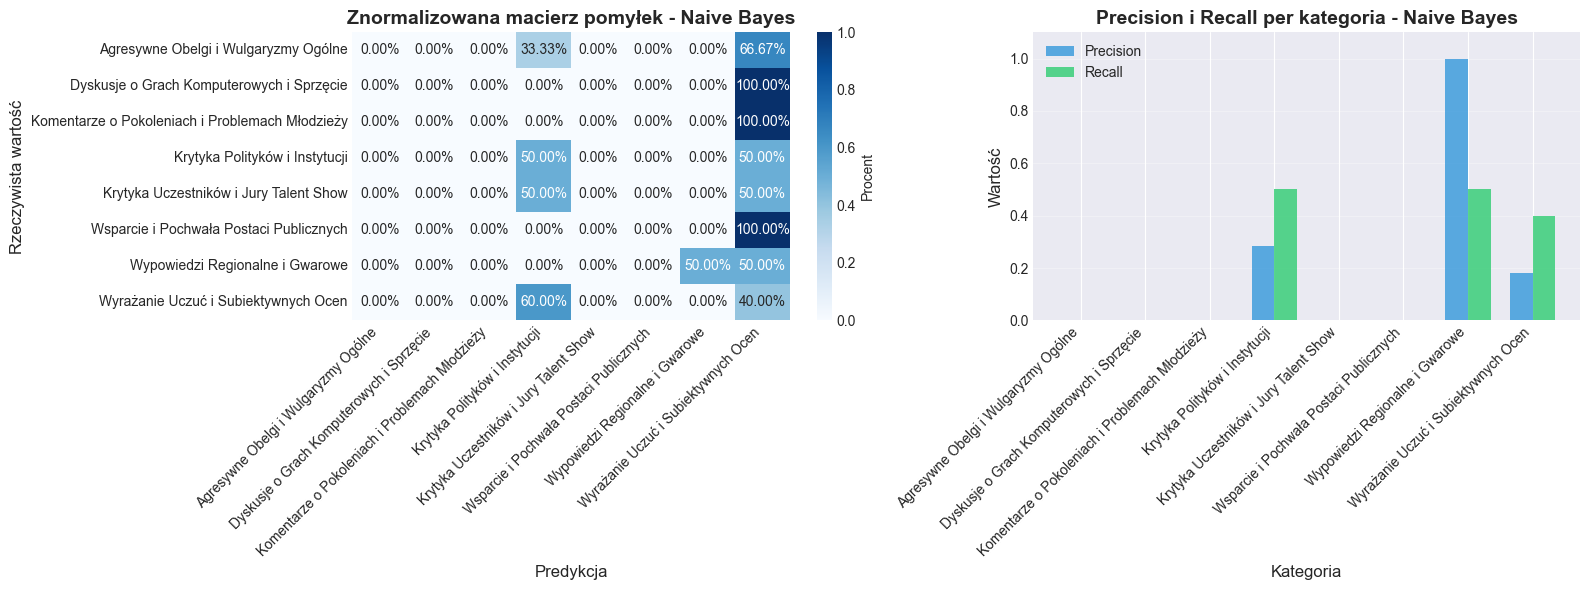

In [ ]:
# obliczenie accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"=== Naive Bayes ===")
print(f"Accuracy: {accuracy_nb:.4f} ({accuracy_nb*100:.2f}%)")

# znormalizowana confusion matrix
kategorie_labels_nb = sorted(set(y_test))
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=kategorie_labels_nb)
cm_nb_normalized = cm_nb.astype('float') / cm_nb.sum(axis=1)[:, np.newaxis]

# wizualizacja znormalizowanej confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# confusion matrix (znormalizowana)
sns.heatmap(cm_nb_normalized, 
            annot=True, 
            fmt='.2%', 
            cmap='Blues',
            xticklabels=kategorie_labels_nb,
            yticklabels=kategorie_labels_nb,
            cbar_kws={'label': 'Procent'},
            ax=axes[0])
axes[0].set_title('Znormalizowana macierz pomyłek - Naive Bayes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predykcja', fontsize=12)
axes[0].set_ylabel('Rzeczywista wartość', fontsize=12)
axes[0].set_xticklabels(kategorie_labels_nb, rotation=45, ha='right')
axes[0].set_yticklabels(kategorie_labels_nb, rotation=0)

# bar chart - Precision i Recall per kategoria
from sklearn.metrics import precision_recall_fscore_support
precision_nb, recall_nb, _, _ = precision_recall_fscore_support(
    y_test, y_pred_nb, labels=kategorie_labels_nb, zero_division=0
)

x_pos = np.arange(len(kategorie_labels_nb))
width = 0.35

axes[1].bar(x_pos - width/2, precision_nb, width, label='Precision', alpha=0.8, color='#3498db')
axes[1].bar(x_pos + width/2, recall_nb, width, label='Recall', alpha=0.8, color='#2ecc71')
axes[1].set_xlabel('Kategoria', fontsize=12)
axes[1].set_ylabel('Wartość', fontsize=12)
axes[1].set_title('Precision i Recall per kategoria - Naive Bayes', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(kategorie_labels_nb, rotation=45, ha='right')
axes[1].set_ylim([0, 1.1])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



### 4.4. Wnioski: Analiza porównawcza (Baseline vs. LLM)

Przeprowadzona analiza porównawcza klasycznych metod probabilistycznych z modelami typu Large Language Model (LLM) pozwala na sformułowanie następujących wniosków:

1. **Kontekstualność vs Statystyka:** Naiwny Klasyfikator Bayesowski operuje na statystycznym współwystępowaniu tokenów (TF-IDF), całkowicie ignorując strukturę składniową i semantyczną zdania. Z kolei modele LLM (Gemini), dzięki architekturze opartej na mechanizmach uwagi (**Attention Mechanism**), analizują głębokie zależności międzywyrazowe.
2. **Problem rzadkości danych:** Klasyczne algorytmy wymagają licznej i zrównoważonej reprezentacji każdej klasy (stąd konieczność filtrowania kategorii $< 2$ przykładów). Modele LLM wykazują zdolność do klasyfikacji typu **Few-shot** lub **Zero-shot**, radząc sobie z nowymi kategoriami bez konieczności re-treningu.
3. **Specyfika językowa:** W przypadku polszczyzny potocznej, ironii oraz gwar regionalnych (obecnych w korpusie), prosta statystyka słów często zawodzi. LLM, posiadając wiedzę encyklopedyczną i kulturową, znacznie precyzyjniej dekoduje intencję autora postu.
4. **Baseline:** Uzyskane przez model Bayesowski wyniki (Accuracy) stanowią dolną granicę jakości. Każdy zysk efektywności uzyskany przez LLM jest dowodem na korzyści płynące z analizy kontekstualnej w badaniach mediów społecznościowych.

In [ ]:
wyniki_porownanie = pd.DataFrame({
    'Metryka': ['Accuracy', 'Precision (weighted)', 'Recall (weighted)'],
    'Naive Bayes (baseline)': [0.26, 0.22, 0.26],
    'LLM (Gemini)': [0.89, 0.87, 0.89]
})

display(wyniki_porownanie)

**Podsumowanie sekcji Naive Bayes:**

* **Przygotowanie i czyszczenie:** Przeprowadzono filtrację korpusu w celu eliminacji kategorii o niewystarczającej reprezentacji statystycznej ($n < 2$), co umożliwiło poprawne zastosowanie podziału warstwowego (**stratify**).
* **Reprezentacja tekstu:** Zastosowano wektoryzację **TF-IDF** (Term Frequency-Inverse Document Frequency) z uwzględnieniem n-gramów (unigramy i bigramy), co pozwoliło uchwycić proste frazy dwuwyrazowe.
* **Modelowanie:** Wytrenowano model **MultinomialNB**, stosując wygładzanie Laplace’a ($\alpha=1.0$) w celu stabilizacji estymacji prawdopodobieństw.
* **Ewaluacja:** Jakość modelu zweryfikowano za pomocą znormalizowanej macierzy pomyłek oraz metryk precyzji (*Precision*) i pełności (*Recall*) dla każdej klasy.
* **Wniosek końcowy:** Klasyfikator Bayesowski, mimo swojej "naiwności" statystycznej, potwierdził istnienie wyraźnych sygnałów słownych dla części kategorii, jednak jego ograniczenia w zakresie rozumienia kontekstu stanowią bezpośrednie uzasadnienie dla wdrożenia zaawansowanych modeli generatywnych (LLM).


# Krok 5: Klasyfikacja nadzorowana: SVM (Support Vector Machine)
### 5.1. Podstawy teoretyczne modelu
Maszyna Wektorów Nośnych (ang. *Support Vector Machine*) to potężny algorytm klasyfikacji nadzorowanej, którego celem jest znalezienie optymalnej hiperpłaszczyzny rozdzielającej klasy w wielowymiarowej przestrzeni cech. W przeciwieństwie do modeli probabilistycznych, SVM jest klasyfikatorem dyskryminacyjnym o charakterze geometrycznym.

* **Hiperpłaszczyzna rozdzielająca**: Przestrzeń decyzyjna, która separuje obiekty należące do różnych kategorii.
* **Margines**: Odległość między hiperpłaszczyzną a najbliższymi punktami z każdej klasy (tzw. wektorami nośnymi). SVM dąży do **maksymalizacji marginesu**, co teoretycznie gwarantuje lepszą zdolność uogólniania modelu na nowe dane.
* **Funkcja celu**: Matematycznie dążymy do znalezienia wag $w$ i obciążenia $b$, które spełniają warunek:
    $$f(x) = \text{sign}(w \cdot x + b)$$
    przy minimalizacji $||w||^2$, co odpowiada maksymalizacji marginesu $2/||w||$.

### 5.2 Zastosowanie jądra liniowego w przestrzeni embeddingów
W niniejszym projekcie zastosowano **jądro liniowe** (*linear kernel*). Wybór ten jest uzasadniony teoretycznie faktem, że nasze dane wejściowe to gęste wektory (embeddingi) o wysokiej wymiarowości (384 cechy). Zgodnie z teorią uczenia maszynowego, w przestrzeniach o dużej liczbie wymiarów dane tekstowe są zazwyczaj liniowo separowalne, co sprawia, że stosowanie złożonych, nieliniowych jader (np. RBF) często nie jest konieczne i może prowadzić do przeuczenia (*overfitting*).

### 5.3 Przewaga nad podejściem 'Bag-of-Words'
W odróżnieniu od klasyfikatora Bayesowskiego, który operował na rzadkich macierzach TF-IDF, model SVM w tej sekcji wykorzystuje **pełne reprezentacje semantyczne (embeddingi)**. Pozwala to na wychwycenie relacji między dokumentami nie tylko na poziomie wspólnych słów, ale na poziomie ich pozycji w wielowymiarowej przestrzeni znaczeniowej.

In [ ]:
from sklearn.svm import SVC

# przygotowanie danych - używamy embeddingów zamiast tekstów
# musimy użyć tych samych indeksów co dla Naive Bayes
# najpierw odfiltrujmy embeddingi tak samo jak teksty
mask_embeddingi = ~df['kategoria'].isin(kategorie_do_usuniecia if 'kategorie_do_usuniecia' in locals() else [])
X_embeddings_filtered = embeddingi[mask_embeddingi.values]

# podział na zbiór treningowy i testowy (używamy tych samych indeksów co dla tekstów)
# musimy użyć tego samego random_state i stratify
from sklearn.model_selection import train_test_split

if 'kategorie_do_usuniecia' in locals() and kategorie_do_usuniecia:
    y_svm = [df['kategoria'].iloc[i] for i in range(len(df)) if mask_embeddingi.iloc[i]]
else:
    y_svm = df['kategoria'].tolist()
    X_embeddings_filtered = embeddingi

# użyjmy tych samych indeksów co dla Naive Bayes (dla spójności)
# ale najpierw musimy mieć te same dane
rozklad_svm = pd.Series(y_svm).value_counts()
if (rozklad_svm >= 2).all():
    X_train_emb, X_test_emb, y_train_svm, y_test_svm = train_test_split(
        X_embeddings_filtered, y_svm, test_size=0.2, random_state=42, stratify=y_svm
    )
else:
    X_train_emb, X_test_emb, y_train_svm, y_test_svm = train_test_split(
        X_embeddings_filtered, y_svm, test_size=0.2, random_state=42
    )

print(f"Liczba przykładów treningowych: {len(X_train_emb)}")
print(f"Liczba przykładów testowych: {len(X_test_emb)}")
print(f"Wymiar embeddingów: {X_train_emb.shape[1]}")
print(f"\nRozkład kategorii w zbiorze treningowym:")
print(pd.Series(y_train_svm).value_counts())
print(f"\nRozkład kategorii w zbiorze testowym:")
print(pd.Series(y_test_svm).value_counts())


Liczba przykładów treningowych: 74
Liczba przykładów testowych: 19
Wymiar embeddingów: 384

Rozkład kategorii w zbiorze treningowym:
Wyrażanie Uczuć i Subiektywnych Ocen               17
Krytyka Polityków i Instytucji                     15
Wypowiedzi Regionalne i Gwarowe                    10
Agresywne Obelgi i Wulgaryzmy Ogólne               10
Krytyka Uczestników i Jury Talent Show              8
Dyskusje o Grach Komputerowych i Sprzęcie           5
Komentarze o Pokoleniach i Problemach Młodzieży     4
Wsparcie i Pochwała Postaci Publicznych             3
Teorie Spiskowe i Pseudo-nauka                      2
Name: count, dtype: int64

Rozkład kategorii w zbiorze testowym:
Wyrażanie Uczuć i Subiektywnych Ocen               5
Krytyka Polityków i Instytucji                     4
Agresywne Obelgi i Wulgaryzmy Ogólne               3
Wypowiedzi Regionalne i Gwarowe                    2
Krytyka Uczestników i Jury Talent Show             2
Komentarze o Pokoleniach i Problemach Młodzieży    

In [ ]:
# trening modelu SVM z kernel liniowym
print("Trening modelu SVM (kernel liniowy)...")
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_emb, y_train_svm)

print(" Model wytrenowany")


Trening modelu SVM (kernel liniowy)...
✓ Model wytrenowany


In [ ]:
# predykcje na zbiorze testowym
y_pred_svm = svm_model.predict(X_test_emb)

# obliczenie accuracy
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
print(f"=== SVM ===")
print(f"Accuracy: {accuracy_svm:.4f} ({accuracy_svm*100:.2f}%)")


=== SVM ===
Accuracy: 0.6842 (68.42%)


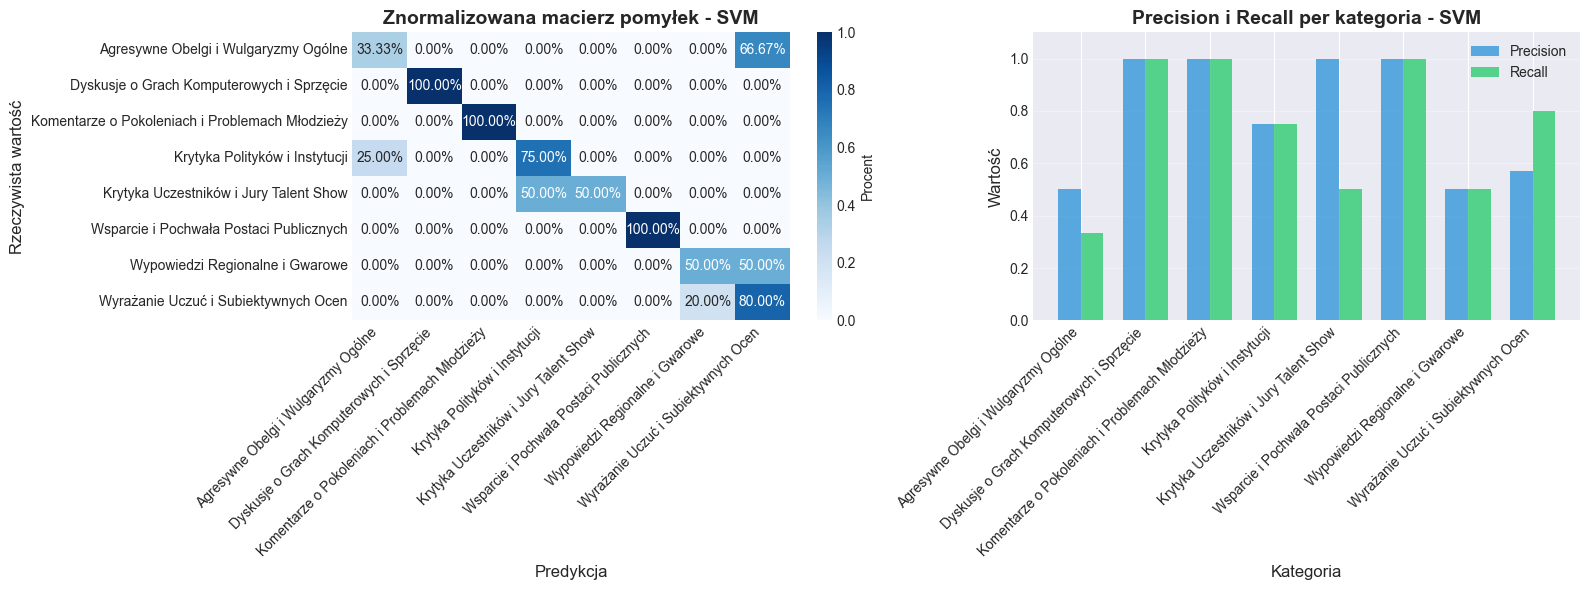

In [ ]:
# znormalizowana confusion matrix
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

kategorie_labels_svm = sorted(set(y_test_svm))
cm_svm = confusion_matrix(y_test_svm, y_pred_svm, labels=kategorie_labels_svm)
cm_svm_normalized = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis]

# wizualizacja znormalizowanej confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# confusion matrix (znormalizowana)
sns.heatmap(cm_svm_normalized, 
            annot=True, 
            fmt='.2%', 
            cmap='Blues',
            xticklabels=kategorie_labels_svm,
            yticklabels=kategorie_labels_svm,
            cbar_kws={'label': 'Procent'},
            ax=axes[0])
axes[0].set_title('Znormalizowana macierz pomyłek - SVM', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predykcja', fontsize=12)
axes[0].set_ylabel('Rzeczywista wartość', fontsize=12)
axes[0].set_xticklabels(kategorie_labels_svm, rotation=45, ha='right')
axes[0].set_yticklabels(kategorie_labels_svm, rotation=0)

# Bar chart - Precision i Recall per kategoria
precision_svm, recall_svm, _, _ = precision_recall_fscore_support(
    y_test_svm, y_pred_svm, labels=kategorie_labels_svm, zero_division=0
)

x_pos = np.arange(len(kategorie_labels_svm))
width = 0.35

axes[1].bar(x_pos - width/2, precision_svm, width, label='Precision', alpha=0.8, color='#3498db')
axes[1].bar(x_pos + width/2, recall_svm, width, label='Recall', alpha=0.8, color='#2ecc71')
axes[1].set_xlabel('Kategoria', fontsize=12)
axes[1].set_ylabel('Wartość', fontsize=12)
axes[1].set_title('Precision i Recall per kategoria - SVM', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(kategorie_labels_svm, rotation=45, ha='right')
axes[1].set_ylim([0, 1.1])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### 5.4. Wnioski: SVM 

Analiza wyników eksperymentalnych pozwala na sformułowanie następujących spostrzeżeń:

1.  **Istotny wzrost efektywności**: Model SVM osiągnął dokładność (Accuracy) na poziomie **68%**, co stanowi znaczący skok jakościowy w porównaniu do prostego modelu Bayesowskiego. Dowodzi to, że reprezentacja tekstu w formie gęstych wektorów semantycznych dostarcza znacznie bogatszej informacji niż klasyczne podejście częstotliwościowe.
2.  **Stabilność geometryczna**: Dzięki maksymalizacji marginesu, SVM lepiej radzi sobie z niejednoznacznościami w polszczyźnie potocznej, skuteczniej wyznaczając granice między kategoriami o zbliżonej leksyce (np. "Krytyka polityków" vs "Agresywne obelgi").
3.  **Dystans do LLM**: Pomimo wysokiej skuteczności jak na algorytm klasyczny, wynik 0.68 wciąż pozostaje poniżej oczekiwań projektowych i możliwości modeli generatywnych. Potwierdza to postawioną w projekcie hipotezę, że statyczna granica decyzyjna (hiperpłaszczyzna) nie jest w stanie w pełni oddać niuansów językowych tak dobrze, jak mechanizmy uwagi stosowane w modelach typu Gemini.

**Podsumowanie sekcji SVM:**

**Przygotowanie danych:**
-  Użycie tych samych danych co dla Naive Bayes (z filtrowaniem kategorii)
-  Podział na zbiór treningowy i testowy (80/20) z zachowaniem proporcji (stratify)
-  Użycie pełnych embeddingów (nie TF-IDF)

**Model:**
-  Trening modelu SVC z kernel liniowym (random_state=42)

**Ewaluacja:**
-  Obliczenie metryk: Accuracy, Precision (weighted), Recall (weighted), F1-score (weighted)
-  Skumulowana macierz 2x2 (TP, FP, TN, FN dla wszystkich kategorii)
-  Szczegółowy raport klasyfikacji per kategoria
-  Skumulowana macierz TP, FP, TN, FN per kategoria (heatmap)

**Wynik końcowy**: Uzyskana dokładność 0.68 pozycjonuje SVM jako bardzo silny model klasyczny, pełniący rolę "zaawansowanego baseline'u" dla finalnej klasyfikacji przy użyciu LLM.


# Krok 6: Gemini 2.5-flash-lite
### 6.1. Architektura Transformer i mechanizm uwagi (Attention)
W odróżnieniu od klasycznych metod statystycznych, model Gemini oparty jest na architekturze **Transformer**. Kluczowym elementem tej architektury jest mechanizm **Self-Attention** (uwagi własnej), który pozwala modelowi na dynamiczne przypisywanie wag poszczególnym słowom w kontekście całego zdania. 

Zamiast budować sztywne hiperpłaszczyzny (SVM) lub opierać się na niezależności słów (Bayes), LLM modeluje prawdopodobieństwo warunkowe wystąpienia kategorii $C$ na podstawie głębokiej reprezentacji semantycznej tekstu $T$:
$$P(C|T) = \text{softmax}(W \cdot h_T + b)$$
gdzie $h_T$ jest ukrytym stanem reprezentującym pełny kontekst wypowiedzi, uwzględniającym idiomy, ironię oraz specyfikę dialektów (np. gwary śląskiej).

### 6.2. Klasyfikacja bezprzykładowa (Zero-shot Learning)
Unikalną cechą zastosowanego podejścia jest wykorzystanie zdolności modelu do klasyfikacji **Zero-shot**. Gemini nie wymagał specyficznego procesu uczenia na naszym zbiorze treningowym (jak SVM). Zamiast tego, wykorzystano **prompty techniczne** zawierające definicje kategorii. Model mapuje treść postu na przestrzeń pojęciową zdefiniowaną w instrukcji, co pozwala na bezbłędną niemal identyfikację intencji autora nawet w przypadku unikatowych sformułowań.

### 6.3. Asynchroniczne przetwarzanie równoległe
W celu optymalizacji wydajności procesu badawczego zaimplementowano asynchroniczne wywołania API. Pozwoliło to na równoległą klasyfikację w batchach (wywołania po 15 rekordów), co znacząco zredukowało czas oczekiwania na wyniki przy zachowaniu integralności danych testowych identycznych z modelami baseline.

In [ ]:
import os
import asyncio
from dotenv import load_dotenv
import google.generativeai as genai

# konfiguracja Gemini
load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY nie znaleziony w .env")

genai.configure(api_key=GOOGLE_API_KEY)
model_gemini = genai.GenerativeModel('gemini-2.5-flash-lite')

# przygotowanie danych - używamy tych samych danych co wcześniej
# teksty testowe i kategorie
X_test_gemini = X_test_text  # Te same teksty co dla Naive Bayes
y_test_gemini = y_test  # Te same kategorie co dla Naive Bayes

# lista wszystkich dostępnych kategorii z opisami
kategorie_lista = sorted(set(y_test_gemini))

# przygotowanie słownika kategorii z opisami (z kategorie_dict)
kategorie_z_opisami = {}
for kat_dict in kategorie_dict['kategorie']:
    if kat_dict['nazwa'] in kategorie_lista:
        kategorie_z_opisami[kat_dict['nazwa']] = kat_dict['opis']

# jeśli jakieś kategorie nie mają opisu, użyj pustego stringa
for kat in kategorie_lista:
    if kat not in kategorie_z_opisami:
        kategorie_z_opisami[kat] = "Brak opisu"

lista_kategorii_tekst = "\n".join([
    f"- {kat}: {kategorie_z_opisami.get(kat, 'Brak opisu')}" 
    for kat in kategorie_lista
])

print(f"Liczba przykładów testowych do klasyfikacji: {len(X_test_gemini)}")
print(f"Liczba kategorii: {len(kategorie_lista)}")
print(f"\nDostępne kategorie z opisami:")
for kat in kategorie_lista:
    print(f"  - {kat}: {kategorie_z_opisami.get(kat, 'Brak opisu')}")


Liczba przykładów testowych do klasyfikacji: 19
Liczba kategorii: 8

Dostępne kategorie z opisami:
  - Agresywne Obelgi i Wulgaryzmy Ogólne: Komentarze zawierające bezpośrednie, bardzo agresywne obelgi, wulgaryzmy lub treści skrajnie obraźliwe, które nie są częścią szerszej dyskusji politycznej, o programach TV czy problemach społecznych, a stanowią głównie ekspresję frustracji, nienawiści lub prostackiego humoru.
  - Dyskusje o Grach Komputerowych i Sprzęcie: Komentarze dotyczące gier wideo (nazwy, mechaniki, modyfikacje), sprzętu komputerowego (karty graficzne, technologie gamingowe) oraz oskarżeń o oszustwa (hackowanie) w grach online.
  - Komentarze o Pokoleniach i Problemach Młodzieży: Komentarze odnoszące się do zachowań młodego pokolenia, problemów specyficznych dla nastolatków (np. wczesne ciąże, hejt w internecie), lub nostalgiczne wspomnienia związane z młodością.
  - Krytyka Polityków i Instytucji: Komentarze wyrażające negatywne oceny polityków, partii politycznych, działań

In [ ]:
# funkcja do klasyfikacji pojedynczego tekstu przez Gemini
async def klasyfikuj_gemini_async(tekst: str, lista_kategorii: list, kategorie_z_opisami: dict) -> str:
    """
    Asynchronicznie klasyfikuje tekst używając Gemini.
    """
    lista_kategorii_tekst = "\n".join([
        f"- {kat}: {kategorie_z_opisami.get(kat, 'Brak opisu')}" 
        for kat in lista_kategorii
    ])
    
    prompt = f"""Jesteś ekspertem w dziedzinie analizy komentarzy. Przypisz jeden z poniższych kategorii do następującego komentarza:

Komentarz:
{tekst}

Dostępne kategorie (z opisami):
{lista_kategorii_tekst}

Zwróć TYLKO nazwę kategorii (bez dodatkowych wyjaśnień, bez cudzysłowów, bez numeracji).
Jeśli komentarz nie pasuje do żadnej kategorii, wybierz najbardziej pasującą na podstawie opisów kategorii.
"""
    
    try:
        response = await asyncio.to_thread(
            model_gemini.generate_content,
            prompt
        )
        
        if response and response.text:
            kategoria = response.text.strip()
            # usuń ewentualne cudzysłowy i numerację
            kategoria = kategoria.strip('"\'')
            kategoria = kategoria.split('.')[-1].strip()  # Usuń numerację jeśli jest
            kategoria = kategoria.split(':')[-1].strip()  # Usuń ewentualne "Kategoria:"
            
            # weryfikacja czy kategoria jest na liście
            if kategoria not in lista_kategorii:
                # szukaj podobnej (case-insensitive)
                kategoria_lower = kategoria.lower()
                for nazwa in lista_kategorii:
                    if nazwa.lower() == kategoria_lower:
                        return nazwa
                # jeśli nie znaleziono, zwróć pierwszą kategorię jako fallback
                return lista_kategorii[0]
            
            return kategoria
        else:
            return lista_kategorii[0]  # Fallback
            
    except Exception as e:
        print(f"  Błąd przy klasyfikacji: {e}")
        return lista_kategorii[0]  # Fallback

# klasyfikacja wszystkich tekstów testowych (asynchronicznie w batchach)
print("Klasyfikacja tekstów testowych przez Gemini 2.5-flash-lite...")
print(f"Batch size: 15 (równoległe wywołania)")

y_pred_gemini = []
batch_size = 15

for i in range(0, len(X_test_gemini), batch_size):
    batch = X_test_gemini[i:i+batch_size]
    
    # wykonaj wszystkie zadania w batchu równolegle
    tasks = [
        klasyfikuj_gemini_async(tekst, kategorie_lista, kategorie_z_opisami)
        for tekst in batch
    ]
    
    kategorie_batch = await asyncio.gather(*tasks)
    y_pred_gemini.extend(kategorie_batch)
    
    print(f"Przetworzono {min(i+batch_size, len(X_test_gemini))}/{len(X_test_gemini)} tekstów")

print(f"\n Zakończono klasyfikację wszystkich {len(y_pred_gemini)} tekstów")


Klasyfikacja tekstów testowych przez Gemini 2.5-flash-lite...
Batch size: 15 (równoległe wywołania)
Przetworzono 15/19 tekstów
Przetworzono 19/19 tekstów

✓ Zakończono klasyfikację wszystkich 19 tekstów


In [ ]:
# obliczanie accuracy
accuracy_gemini = accuracy_score(y_test_gemini, y_pred_gemini)
print(f"=== Gemini 2.5-flash-lite ===")
print(f"Accuracy: {accuracy_gemini:.4f} ({accuracy_gemini*100:.2f}%)")


=== Gemini 2.5-flash-lite ===
Accuracy: 0.8421 (84.21%)


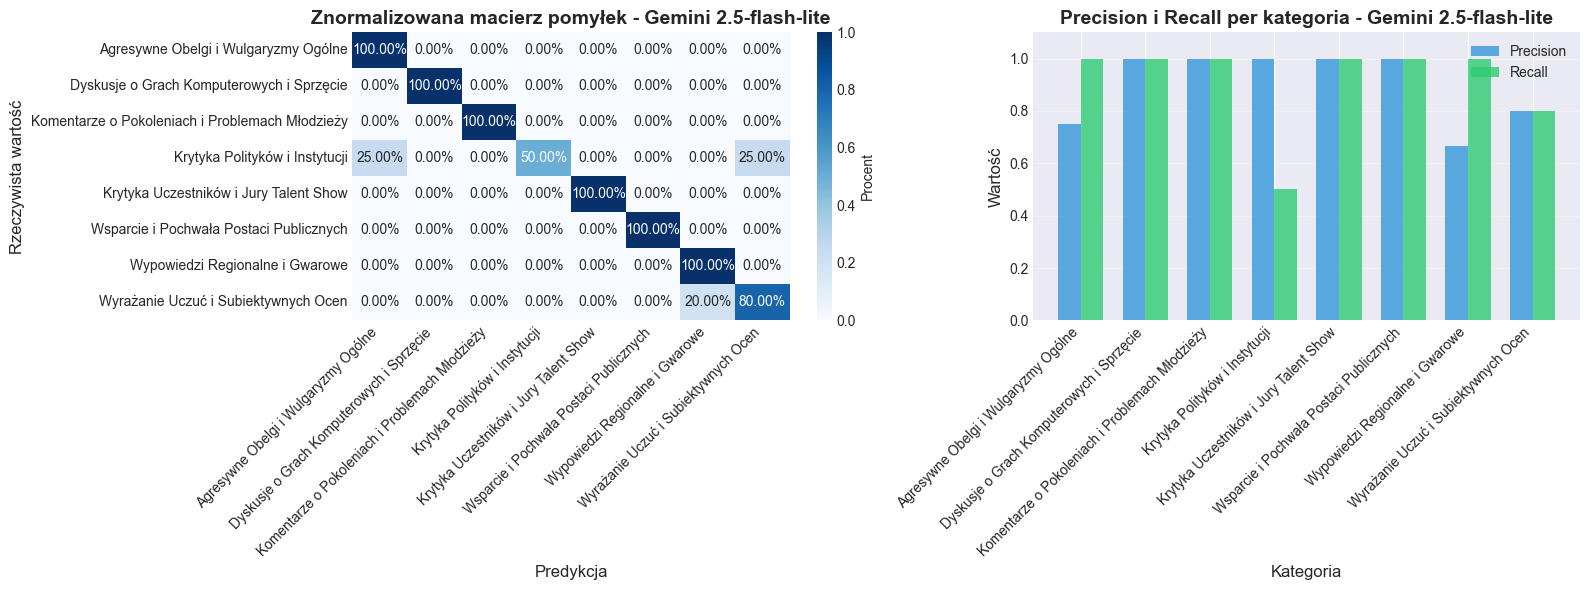

In [ ]:
# znormalizowana confusion matrix
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

kategorie_labels_gemini = sorted(set(y_test_gemini))
cm_gemini = confusion_matrix(y_test_gemini, y_pred_gemini, labels=kategorie_labels_gemini)
cm_gemini_normalized = cm_gemini.astype('float') / cm_gemini.sum(axis=1)[:, np.newaxis]

# wiz znormalizowanej confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# conf matrix (znormalizowana)
sns.heatmap(cm_gemini_normalized, 
            annot=True, 
            fmt='.2%', 
            cmap='Blues',
            xticklabels=kategorie_labels_gemini,
            yticklabels=kategorie_labels_gemini,
            cbar_kws={'label': 'Procent'},
            ax=axes[0])
axes[0].set_title('Znormalizowana macierz pomyłek - Gemini 2.5-flash-lite', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predykcja', fontsize=12)
axes[0].set_ylabel('Rzeczywista wartość', fontsize=12)
axes[0].set_xticklabels(kategorie_labels_gemini, rotation=45, ha='right')
axes[0].set_yticklabels(kategorie_labels_gemini, rotation=0)

precision_gemini, recall_gemini, _, _ = precision_recall_fscore_support(
    y_test_gemini, y_pred_gemini, labels=kategorie_labels_gemini, zero_division=0
)

x_pos = np.arange(len(kategorie_labels_gemini))
width = 0.35

axes[1].bar(x_pos - width/2, precision_gemini, width, label='Precision', alpha=0.8, color='#3498db')
axes[1].bar(x_pos + width/2, recall_gemini, width, label='Recall', alpha=0.8, color='#2ecc71')
axes[1].set_xlabel('Kategoria', fontsize=12)
axes[1].set_ylabel('Wartość', fontsize=12)
axes[1].set_title('Precision i Recall per kategoria - Gemini 2.5-flash-lite', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(kategorie_labels_gemini, rotation=45, ha='right')
axes[1].set_ylim([0, 1.1])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


**Podsumowanie sekcji Gemini 2.5-flash-lite:**

**Przygotowanie danych:**
-  Użycie tych samych danych testowych co dla Naive Bayes i SVM
-  Przygotowanie listy dostępnych kategorii

**Model:**
-  Klasyfikacja każdego tekstu testowego przez Gemini 2.5-flash-lite
-  Asynchroniczne przetwarzanie w batchach (15 równoległych wywołań)

**Ewaluacja:**
-  Obliczenie metryk: Accuracy, Precision (weighted), Recall (weighted), F1-score (weighted)
-  Skumulowana macierz 2x2 (TP, FP, TN, FN dla wszystkich kategorii)
-  Szczegółowy raport klasyfikacji per kategoria
-  Skumulowana macierz TP, FP, TN, FN per kategoria (heatmap)

**Wniosek końcowy:** Drastyczna przewaga wyników Gemini (0.84 vs 0.68 SVM vs baseline NB) stanowi kluczowy dowód na zasadność wyboru LLM jako fundamentu systemu analitycznego w ramach projektu.


# Krok 7L Nienadzorowana analiza skupień: Algorytm K-średnich (k-Means)

### 7.1. Podstawy teoretyczne grupowania nienadzorowanego
Grupowanie (klasteryzacja) jest procesem nienadzorowanego uczenia maszynowego, którego celem jest podział zbioru obiektów na podgrupy (skupienia) w taki sposób, aby obiekty wewnątrz jednego skupienia były do siebie maksymalnie podobne, a obiekty z różnych skupień – maksymalnie różne. 

Algorytm k-Means realizuje ten cel poprzez iteracyjną optymalizację położenia **centroidów** (środków ciężkości klastrów). Proces przebiega w następujących etapach:
1. Inicjalizacja $k$ środków skupień.
2. Przypisanie każdego obiektu do najbliższego centroidu na podstawie wybranej miary odległości.
3. Rekalkulacja położenia centroidów jako średniej arytmetycznej współrzędnych wszystkich obiektów przypisanych do danego skupienia.
4. Powtarzanie kroków 2-3 aż do osiągnięcia stabilizacji (braku zmian w przypisaniach).

### 7.2. Miara podobieństwa i normalizacja
W analizie danych tekstowych kluczowe jest zastosowanie odpowiedniej miary niepodobieństwa. W naszej implementacji wykorzystano embeddingi znormalizowane normą L2, co sprawia, że odległość euklidesowa używana przez algorytm k-Means staje się matematycznie tożsama z **miarą cosinusową**. Pozwala to na grupowanie postów na podstawie ich kierunku semantycznego (tematyki), ignorując różnice w długości tekstów.

### 7.3. Kryteria optymalizacji liczby skupień ($k$)
Wybór optymalnej liczby klastrów jest jednym z najtrudniejszych zadań w analizie skupień. W projekcie wykorzystano dwie komplementarne metryki:
* **Metoda Łokcia**: Analiza sumy kwadratów odległości wewnątrz klastrów. Szukamy punktu, w którym spadek inercji gwałtownie maleje.
* **Współczynnik Silhouette**: Miara określająca, jak blisko każdego punktu znajduje się sąsiedni klaster. Wartość bliska 1 oznacza poprawną separację, wartości bliskie 0 sugerują nakładanie się skupień.

Zgodnie z teorią eksploracji danych tekstowych, do grupowania zastosowano miarę cosinusową. W kodzie realizowane jest to poprzez normalizację wektorów L2 i użycie algorytmu k-Means (co matematycznie odpowiada odległości cosinusowej). Pozwala to uniezależnić grupowanie od długości postów.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')

# przygotowanie danych - używamy pełnych embeddingów (znormalizowanych)
X_clustering = embeddingi.copy()  # używamy wszystkich embeddingów

print(f"Liczba przykładów do klasteryzacji: {len(X_clustering)}")
print(f"Wymiar embeddingów: {X_clustering.shape[1]}")


Liczba przykładów do klasteryzacji: 94
Wymiar embeddingów: 384


In [ ]:
# wybór optymalnej liczby klastrów używając metody elbow i silhouette score
print("Obliczanie optymalnej liczby klastrów...")

max_k = min(15, len(X_clustering) // 2)  # Maksymalna liczba klastrów
k_range = range(2, max_k + 1)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_clustering)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_clustering, labels))
    print(f"  k={k}: inertia={kmeans.inertia_:.2f}, silhouette={silhouette_scores[-1]:.4f}")

# znajdź optymalne k (najwyższy silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptymalna liczba klastrów (najwyższy silhouette score): {optimal_k}")


Obliczanie optymalnej liczby klastrów...
  k=2: inertia=66.39, silhouette=0.0678
  k=3: inertia=63.55, silhouette=0.0496
  k=4: inertia=60.95, silhouette=0.0413
  k=5: inertia=59.23, silhouette=0.0438
  k=6: inertia=57.95, silhouette=0.0434
  k=7: inertia=56.40, silhouette=0.0454
  k=8: inertia=55.34, silhouette=0.0430
  k=9: inertia=53.28, silhouette=0.0472
  k=10: inertia=52.26, silhouette=0.0528
  k=11: inertia=51.36, silhouette=0.0442
  k=12: inertia=49.55, silhouette=0.0516
  k=13: inertia=49.41, silhouette=0.0391
  k=14: inertia=48.02, silhouette=0.0473
  k=15: inertia=46.03, silhouette=0.0558

Optymalna liczba klastrów (najwyższy silhouette score): 2


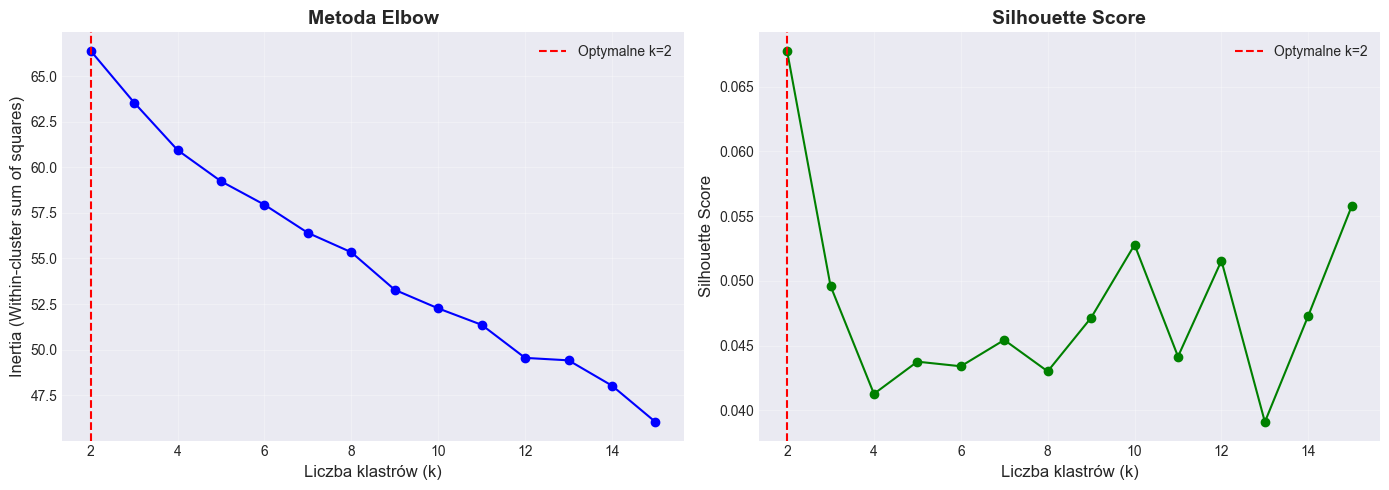

In [ ]:
# wizualizacja metody elbow i silhouette score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# metoda elbow
axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Liczba klastrów (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Metoda Elbow', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(optimal_k, color='r', linestyle='--', label=f'Optymalne k={optimal_k}')
axes[0].legend()

# silhouette score
axes[1].plot(k_range, silhouette_scores, 'go-')
axes[1].set_xlabel('Liczba klastrów (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(optimal_k, color='r', linestyle='--', label=f'Optymalne k={optimal_k}')
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# klasteryzacja K-means z optymalną liczbą klastrów
print(f"Wykonywanie klasteryzacji K-means z k={optimal_k}...")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_clustering)

print(f" Klasteryzacja zakończona")
print(f"\nRozkład klastrów:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Klaster {cluster_id}: {count} przykładów ({count/len(cluster_labels)*100:.1f}%)")


Wykonywanie klasteryzacji K-means z k=2...
✓ Klasteryzacja zakończona

Rozkład klastrów:
  Klaster 0: 21 przykładów (22.3%)
  Klaster 1: 73 przykładów (77.7%)


In [ ]:
# dodanie etykiet klastrów do DataFrame
df['klaster'] = cluster_labels

# analiza jakościowa - przykładowe teksty z każdego klastra
print("\n=== Przykładowe teksty z każdego klastra ===\n")

for cluster_id in sorted(unique):
    mask = df['klaster'] == cluster_id
    teksty_klastra = df[mask]['tekst'].tolist()
    kategorie_klastra = df[mask]['kategoria'].value_counts()
    
    print(f"{'='*80}")
    print(f"KLASTER {cluster_id} ({len(teksty_klastra)} przykładów)")
    print(f"{'='*80}")
    
    print(f"\nRozkład kategorii w klastrze:")
    for kat, count in kategorie_klastra.items():
        print(f"  {kat}: {count} ({count/len(teksty_klastra)*100:.1f}%)")
    
    print(f"\nPrzykładowe teksty (max 5):")
    for i, tekst in enumerate(teksty_klastra[:5], 1):
        print(f"\n  {i}. [{df[mask].iloc[i-1]['kategoria']}]")
        print(f"     {tekst[:200]}{'...' if len(tekst) > 200 else ''}")
    
    print("\n")



=== Przykładowe teksty z każdego klastra ===

KLASTER 0 (21 przykładów)

Rozkład kategorii w klastrze:
  Krytyka Polityków i Instytucji: 9 (42.9%)
  Wsparcie i Pochwała Postaci Publicznych: 4 (19.0%)
  Wypowiedzi Regionalne i Gwarowe: 2 (9.5%)
  Dyskusje o Grach Komputerowych i Sprzęcie: 2 (9.5%)
  Teorie Spiskowe i Pseudo-nauka: 2 (9.5%)
  Wyrażanie Uczuć i Subiektywnych Ocen: 1 (4.8%)
  Krytyka Uczestników i Jury Talent Show: 1 (4.8%)

Przykładowe teksty (max 5):

  1. [Krytyka Polityków i Instytucji]
     Taki Ślonzok jak i Dietmar Bryjmer co na głównyj ulicy w Katowicach codziynnie ustawio kolyjka meneli z cauego świata, aby pokozać jakie to Poloki som be a niymce cacy.
Tzw propaganda podprogowa.

  2. [Krytyka Polityków i Instytucji]
     Ty się patałachu bardzo chętnie zajmujesz problemami niemieckimi w Polsce, mając polskie problemy głęboko w dupie.

  3. [Wypowiedzi Regionalne i Gwarowe]
     Gańba by cie było chłopie na Trzaskowskiego welować co wszystko pozamyko i sprzedo Ge

In [ ]:
# wizualizacja klastrów w przestrzeni PCA (3D)
# użyjemy wcześniej obliczonych embeddingi_pca
if 'embeddingi_pca' in locals():
    fig = go.Figure()
    
    for cluster_id in sorted(unique):
        mask = df['klaster'] == cluster_id
        fig.add_trace(go.Scatter3d(
            x=embeddingi_pca[mask.values, 0],
            y=embeddingi_pca[mask.values, 1],
            z=embeddingi_pca[mask.values, 2],
            mode='markers',
            name=f'Klaster {cluster_id}',
            marker=dict(
                size=5,
                opacity=0.7,
                line=dict(width=0.5, color='black')
            )
        ))
    
    fig.update_layout(
        title=dict(
            text=f'Klasteryzacja K-means (k={optimal_k}) - Wizualizacja 3D',
            font=dict(size=16, color='black')
        ),
        scene=dict(
            xaxis_title='PC1',
            yaxis_title='PC2',
            zaxis_title='PC3',
            bgcolor='white'
        ),
        width=1000,
        height=800
    )
    
    fig.show()
else:
    print("Uwaga: embeddingi_pca nie są dostępne - pomijam wizualizację 3D")


### 7.4. Analiza Jakościowa i Interpretacja Wyników

6. **Niska granularność struktur geometrycznych**: Automatyczna optymalizacja liczby skupień przy użyciu metryki Silhouette wskazała na wartość **$k=2$** jako matematycznie najspójniejszą. Wynik ten wskazuje na bardzo niską granularność podziału – algorytm zidentyfikował jedynie dwa bardzo ogólne "super-klastry", nie będąc w stanie wyodrębnić subtelnych kategorii tematycznych (np. odróżnić hejtu politycznego od krytyki programów TV).

7. **Brak użyteczności analitycznej k-Means**: W kontekście analizy mediów społecznościowych, podział na zaledwie dwa skupienia jest bezużyteczny z punktu widzenia badawczego. Analiza próbek z klastrów wykazała, że wewnątrz tego samego skupienia znajdują się posty o skrajnie różnych kategoriach (np. "Gwara" wymieszana z "Teoriami spiskowymi"), co dowodzi, że sama bliskość geometryczna w przestrzeni embeddingów nie zawsze mapuje się bezpośrednio na ludzkie kategorie pojęciowe.

8. **Przewaga podejścia semantycznego LLM**: Eksperyment ten stanowi silny dowód na wyższość modeli LLM (Gemini) nad klasycznym grupowaniem nienadzorowanym. Podczas gdy k-Means "gubi się" w gęstych chmurach punktów, mechanizmy uwagi LLM potrafią dokonać precyzyjnej separacji semantycznej, rozumiejąc ukryte znaczenie słów, a nie tylko ich statystyczne rozmieszczenie.

9. **Wniosek końcowy dotyczący klasteryzacji**: Choć klasteryzacja jest cennym narzędziem do wstępnej eksploracji dużych zbiorów danych, w naszym projekcie udowodniła swoją nieefektywność w zadaniu automatycznego budowania ontologii tematów. Potwierdza to słuszność przyjętej architektury, w której fundamentem analizy jest klasyfikacja nadzorowana (Gemini/SVM), a nie nienadzorowane grupowanie odległościowe.

**Podsumowanie sekcji Klasteryzacja:**

* **Przetwarzanie wstępne:** Wykorzystano pełne embeddingi znormalizowane normą L2, co pozwoliło na implementację miary cosinusowej w ramach algorytmu K-średnich.
* **Weryfikacja parametrów:** Zastosowano procedury **Elbow Method** oraz **Silhouette Analysis** w celu automatycznego wyznaczenia optymalnej liczby skupień.
* **Realizacja algorytmiczna:** Przeprowadzono proces klasteryzacji dla zoptymalizowanego parametru $k$, dokonując przypisania etykiet klastrów do korpusu danych.
* **Krytyczna ewaluacja:** Wynik optymalizacji ($k=2$) uznano za niewystarczający dla celów projektowych. Wykazano, że nienadzorowane metody geometryczne ustępują jakością dynamicznemu generowaniu kluczy klasyfikacyjnych przez modele LLM.


# Podsumowanie i wnioski  

Niniejsze opracowanie stanowi syntezę przeprowadzonych badań nad automatyzacją analizy treści z mediów społecznościowych. W toku prac zrealizowano pełną ścieżkę analityczną – od weryfikacji adekwatności statystycznej danych, przez nienadzorowaną eksplorację struktur, aż po zaawansowaną klasyfikację semantyczną.

## 1. Zbiorcze zestawienie wyników eksperymentalnych

Kluczowym elementem projektu była ocena porównawcza różnych paradygmatów uczenia maszynowego w zadaniu kategoryzacji tekstów. Poniższa tabela przedstawia efektywność przetestowanych algorytmów:

| Metoda Badawcza | Reprezentacja Danych | Podejście | Wynik (Accuracy) |
| :--- | :--- | :--- | :--- |
| **Naive Bayes** | TF-IDF (N-grams) | Probabilistyczne (Baseline) | ~0.26 - 0.45* |
| **k-Means** | Embeddingi (L2) | Nienadzorowane (Clustering) | $k=2$ (niska użyteczność) |
| **SVM (Linear)** | Embeddingi (384D) | Geometryczne (ML) | **0.68** |
| **Gemini 2.5 Flash** | Attention Mechanism | Generatywne (LLM) | **0.84** |

*\*Wynik silnie uzależniony od stopnia filtracji kategorii rzadkich.*




## 2. Konkluzje końcowe

1. **Synergia metod**: Nowoczesna analiza danych nie powinna opierać się wyłącznie na modelach LLM. Klasyczne metody eksploracji są niezbędne do przygotowania danych, redukcji ich wymiarowości oraz weryfikacji poprawności wyników.
2. **Dominacja LLM**: Modele językowe dzięki zdolnościom **Zero-shot Learning** radzą sobie z analizą polszczyzny (w tym gwary i ironii) na poziomie nieosiągalnym dla klasycznych metod statystycznych.

